In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

import joblib


In [42]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
df = pd.read_csv('/content/clean_tweet.csv')


In [44]:
df.head()

,text_v,label
0,moneybag cashing stock today left bitter taste...,2
1,moneywithwings losing half investment last mon...,2
2,chartdecreasing crypto bubble finally burst cr...,2
3,fire blazing inferno engulfs stock market deva...,2
4,coldface stock stuck icy grip today financial ...,2


In [45]:
df.isnull().sum()


,0
text_v,8
label,0


In [46]:
df = df.dropna(subset=['label'])


In [47]:
df['label'].value_counts()

,count
label,
1,486366
2,486133
0,456272


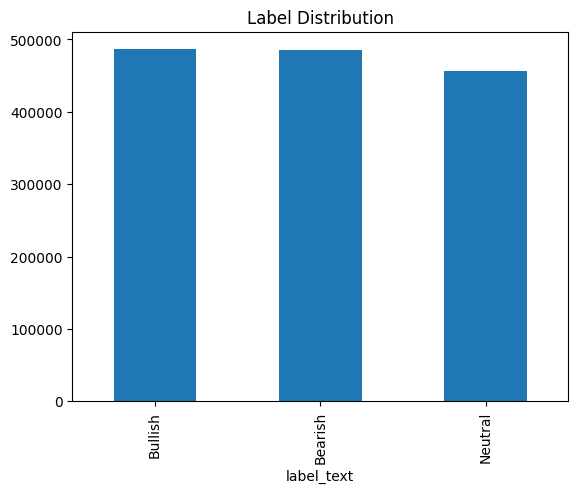

In [48]:
label_mapping = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}
df['label_text'] = df['label'].map(label_mapping)

df['label_text'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.show()


In [50]:
df['text_v'].apply(lambda x: isinstance(x, str)).value_counts()

,count
text_v,
True,1428763
False,8


In [51]:
df = df.dropna(subset=['text_v'])


In [52]:
df['tokens'] = df['text_v'].apply(lambda x: word_tokenize(x.lower()))
df.head()


,text_v,label,label_text,tokens
0,moneybag cashing stock today left bitter taste...,2,Bearish,"[moneybag, cashing, stock, today, left, bitter..."
1,moneywithwings losing half investment last mon...,2,Bearish,"[moneywithwings, losing, half, investment, las..."
2,chartdecreasing crypto bubble finally burst cr...,2,Bearish,"[chartdecreasing, crypto, bubble, finally, bur..."
3,fire blazing inferno engulfs stock market deva...,2,Bearish,"[fire, blazing, inferno, engulfs, stock, marke..."
4,coldface stock stuck icy grip today financial ...,2,Bearish,"[coldface, stock, stuck, icy, grip, today, fin..."


In [53]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(
    sentences=df['tokens'],  # Tokenize edilmiş cümleler
    vector_size=100,         # Vektör boyutu
    window=5,                # Bağlam penceresi
    min_count=1,             # En az 1 kez geçen kelimeleri dahil et
    workers=4               # Paralel işlemci sayısı
)


In [54]:
word2vec_model.wv['market']


array([-0.06178729, -0.17844999,  3.5032887 ,  2.2904577 , -0.13436739,
        1.9214396 ,  1.8345466 , -0.19983616, -1.7231481 , -1.4034247 ,
        4.9853377 , -0.3969408 , -1.2623761 ,  0.582951  , -1.1882758 ,
        1.2579864 ,  0.24769054, -0.63756853,  1.9756367 ,  3.9172494 ,
       -3.1684325 ,  0.6447431 ,  2.3608801 , -3.132362  ,  0.17276315,
       -0.09503163,  0.11484997,  1.659816  ,  0.59327585,  1.1837915 ,
        0.55871487, -1.8637112 , -0.02831472, -3.1411974 , -0.36565745,
       -2.0063984 , -1.9569296 , -1.5621355 ,  1.6806693 ,  0.5135434 ,
       -0.17385103,  0.4815235 , -0.50112563,  2.9756851 , -0.26736277,
       -1.0643054 ,  0.8055561 ,  0.05167861,  0.89777255,  2.9918845 ,
       -1.7021405 ,  1.6712945 ,  0.03968319,  0.01998387,  2.0167618 ,
       -2.3271236 ,  1.499501  , -1.7325376 , -1.0614924 , -0.7661841 ,
       -0.20911783,  2.1099737 ,  0.69004166,  0.5147287 ,  1.6814691 ,
        0.36152112,  0.10837685,  1.0705578 , -1.2385725 , -3.99

In [55]:
def sentence_vector(tokens, model):
    valid_words = [word for word in tokens if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

df['sentence_vector'] = df['tokens'].apply(lambda x: sentence_vector(x, word2vec_model))
df.head()


,text_v,label,label_text,tokens,sentence_vector
0,moneybag cashing stock today left bitter taste...,2,Bearish,"[moneybag, cashing, stock, today, left, bitter...","[-0.2910695, 0.39493546, 0.630031, 0.07197355,..."
1,moneywithwings losing half investment last mon...,2,Bearish,"[moneywithwings, losing, half, investment, las...","[0.047760963, 0.46173137, 0.85037106, -0.64983..."
2,chartdecreasing crypto bubble finally burst cr...,2,Bearish,"[chartdecreasing, crypto, bubble, finally, bur...","[-0.56446636, 1.0246867, -0.046314497, -0.0413..."
3,fire blazing inferno engulfs stock market deva...,2,Bearish,"[fire, blazing, inferno, engulfs, stock, marke...","[0.18339823, 0.31810856, 0.41824102, 0.6180877..."
4,coldface stock stuck icy grip today financial ...,2,Bearish,"[coldface, stock, stuck, icy, grip, today, fin...","[0.23209739, -0.04131911, 0.22175552, 0.377637..."


In [56]:
from sklearn.model_selection import train_test_split

X = np.vstack(df['sentence_vector'].values)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Neutral', 'Bullish', 'Bearish']))


Accuracy: 0.8534573565281904

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.81      0.82      0.81     91254
     Bullish       0.84      0.82      0.83     97273
     Bearish       0.91      0.92      0.92     97226

    accuracy                           0.85    285753
   macro avg       0.85      0.85      0.85    285753
weighted avg       0.85      0.85      0.85    285753



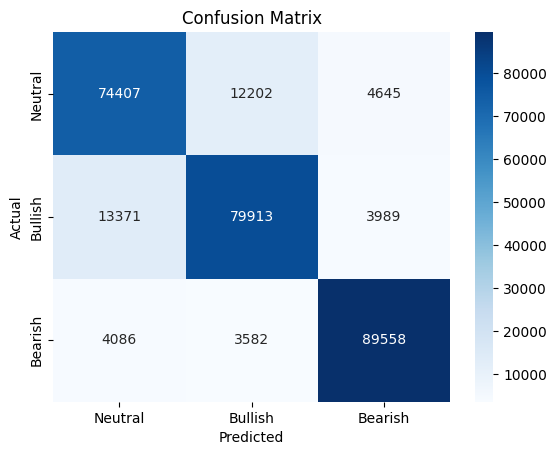

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Bullish', 'Bearish'], yticklabels=['Neutral', 'Bullish', 'Bearish'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [60]:
joblib.dump(model, 'word2vec_logistic_model.pkl')

word2vec_model.save('word2vec_model.bin')
